# Solution Traces

Goal: For given task, visualize common traces (leading / not leading to the correct solution). 

In [11]:
# Settings and imports.
%matplotlib inline
from collections import OrderedDict
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import parallel_coordinates
import seaborn as sns
import data

sns.set()
pd.options.display.float_format = '{:.2f}'.format

# Preparing Data

In [5]:
ts = data.load('robomission-2018-03-10/task_sessions.csv')
# Only consider sessions with an interaction.
ts = ts[ts.time_spent > 0]
tasks = data.load('robomission-2018-03-10/tasks.csv')
snapshots = data.load('robomission-2018-03-10/program_snapshots.csv')

# Program Simulation

In [10]:
tasks.loc[3].setting

'{"length": 3, "fields": [[["b", []], ["b", []], ["b", []], ["b", []], ["b", []]], [["k", ["A"]], ["k", []], ["k", ["A"]], ["k", []], ["k", ["A"]]], [["k", []], ["k", ["A"]], ["k", []], ["k", ["A"]], ["k", []]], [["k", ["A"]], ["k", []], ["k", ["A"]], ["k", []], ["k", ["A"]]], [["k", []], ["k", ["A"]], ["k", []], ["k", ["A"]], ["k", []]], [["k", ["A"]], ["k", []], ["k", ["A"]], ["k", []], ["k", ["A"]]], [["k", []], ["k", ["A"]], ["k", []], ["k", ["A"]], ["k", []]], [["k", ["A"]], ["k", []], ["k", ["A"]], ["k", []], ["k", ["A"]]], [["k", []], ["k", []], ["k", ["S"]], ["k", []], ["k", []]]]}'

In [106]:
MAX_STEPS = 100

def find_spaceship(world):
    for i, row in enumerate(world):
        for j, field in enumerate(row):
            _color, objects = field
            if 'S' in objects:
                return (i, j)
            
def indent(n):
    return ' ' * 4 * n

def to_python(minirobocode):
    lines = []
    nest = 0
    test = False
    for token in minirobocode:
        if not test:
            lines.append(indent(nest) + 'self.check_n_steps()')
        if token == '{':
            nest += 1
            test = False
        elif token == '}':
            nest -= 1
            continue
        elif token == 'W':
            test = True
            lines.append(indent(nest) + 'while')
        elif token == 'I':
            test = True
            lines.append(indent(nest) + 'if')
        elif token == 'R':
            lines.append(indent(nest) + 'repeat')
        elif token == 'f':
            lines.append(indent(nest) + 'self.fly()')
        elif token == 'l':
            lines.append(indent(nest) + 'self.left()')
        elif token == 'r':
            lines.append(indent(nest) + 'self.right()')
        elif token == 's':
            lines.append(indent(nest) + 'self.shoot()')
        elif token == '/':
            lines.append(indent(nest-1) + 'else:')
        # TODO: fix to make it work with position testing
        elif test and token == '!':
            lines[-1] += ' not'
        elif test and token in 'yrgbk':
            lines[-1] += ' self.color() == "{c}":'.format(c=token)
        elif token in '0123456789':
            lines[-1] += ' ' + token + ':'
        # TODO: position testing    
    program = '\n'.join(lines)
    return program

def get_world_size(world):
    return len(world), len(world[0])

class Simulator:
    MAX_STEPS = 100
    def __init__(self, world):
        self.colors = {
            (i, j): field[0]
            for i, row in enumerate(world)
            for j, field in enumerate(row)}
        self.objects = {
            (i, j): field[1]
            for i, row in enumerate(world)
            for j, field in enumerate(row)}
        self.spaceship = find_spaceship(world)
        self.fields = [self.spaceship]
        self.n_step = 0
        self.size = get_world_size(world)
    
    def simulate(self, program):
        if not program or type(program) != str:
            return
        program = to_python(program)
        #print('program', program)
        try:
            exec(program)
        except StopIteration:
            pass # Check for infinite loops.
        except SyntaxError:
            pass # Check for invalid programs.
    
    # TODO: check for asteroids, wormholes and being outside
    def fly(self):
        self.spaceship = (self.spaceship[0]-1, self.spaceship[1])
        if not self.is_dead():
            self.fields.append(self.spaceship)
        
    def left(self):
        self.spaceship = (self.spaceship[0]-1, self.spaceship[1]-1)
        if not self.is_dead():
            self.fields.append(self.spaceship)
        
    def right(self):
        self.spaceship = (self.spaceship[0]-1, self.spaceship[1]+1)
        if not self.is_dead():
            self.fields.append(self.spaceship)
        
    def shoot(self):
        # TODO: shoot
        self.spaceship = (self.spaceship[0]-1, self.spaceship[1])
        if not self.is_dead():
            self.fields.append(self.spaceship)
        
    def color(self):
        return self.colors[self.spaceship]

    def is_dead(self):
        # TODO: check for asteroids, meteoroids
        if not(0 <= self.spaceship[0] < self.size[0]):
            return True
        if not(0 <= self.spaceship[1] < self.size[1]):
            return True
        return False
    
    def check_n_steps(self):
        # TODO: Rename to reflect that it also looks for failure.
        self.n_step += 1
        if self.n_step >= self.MAX_STEPS:
            raise StopIteration
        if self.is_dead():
            raise StopIteration

def simulate(world, program):        
    sim = Simulator(world)
    sim.simulate(program) 
    return sim.fields

world = json.loads(tasks.loc[3].setting)['fields']
#simulate(world, program='lrlr')

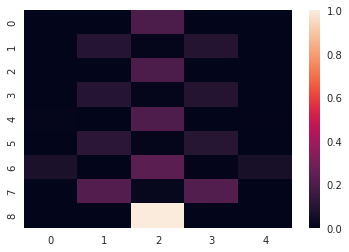

In [108]:
def plot_heatmap(task_name='zig-zag', solved=True):
    task = tasks[tasks.name == task_name]
    world = json.loads(tasks.loc[3].setting)['fields']
    task_id = task.index[0]
    ts_rel = ts[ts.task == task_id]
    ts_rel = ts_rel[ts_rel.solved == solved]
    snapshots_rel = snapshots[snapshots.task_session.isin(ts_rel.index)]
    size = get_world_size(world)
    visited_matrix = np.zeros(size)
    for program in snapshots_rel.program:  #['lrlr', 'W!b{lr}']: 
        fields = simulate(world, program)
        for row, col in fields:
            visited_matrix[row, col] += 1
    # TODO: parsing all programs, colormap, keep aspect ratio
    #return visited_matrix
    sns.heatmap(visited_matrix / visited_matrix.max())

plot_heatmap()

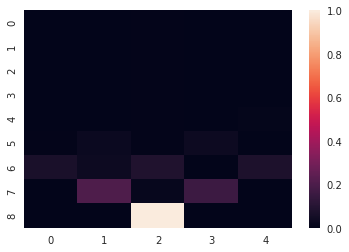

In [109]:
plot_heatmap(solved=False)